In [1]:
# This notebook inspects the Ca+ and DA data fro mexperiment tagged as HSFP_636970_2022-11-14-12-34-14
# These data are used only to determine parameters for the simulation that the network will be trained on
# The trained model will be simply applied to this data.
# Notch filters are an


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

from rich import print as pprint
from sourcesep.utils.config import load_config
from sourcesep.sim import SimData

Paths are for dataset tagged: all
Paths are for dataset tagged: all


405     473     561
EGFP    0.1732  0.8143  0.0043
mApple  0.0069  0.0920  0.8972

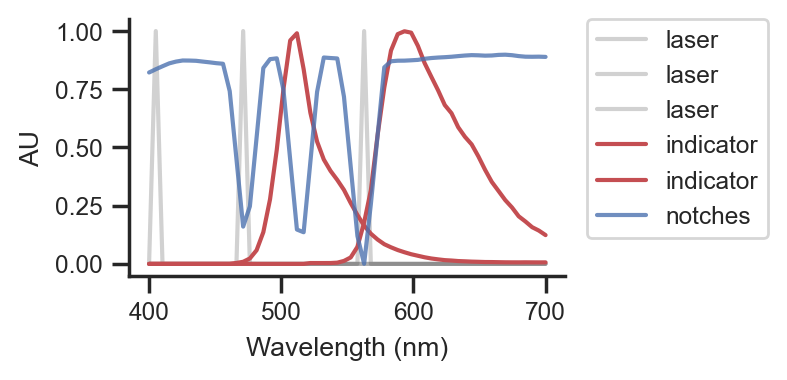

In [2]:
paths = load_config(dataset_key="all")
sim = SimData(T=400 * 40, cfg_path=paths["root"] / "sim_HSFP_636970_2022-11-14-12-34-14.toml")

S = sim.get_S()
W = sim.get_W()
E = sim.get_E()
notches = sim.get_notches()
Mu_ox, Mu_dox = sim.get_Mu()
pprint(sim.W_df)

f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(sim.L_arr, sim.E.T, "k", alpha=0.2, label="laser")
ax.plot(sim.L_arr, sim.S.T, "r", label="indicator")
ax.plot(sim.L_arr, sim.notches, "b", alpha=0.8, label="notches")
ax.set(xlabel="Wavelength (nm)", ylabel="AU")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()
plt.show()

In [3]:
# sample generation time cost
dat = sim.compose()

In [4]:
# reshaping to match data analysis of Ca-DA signal
xj = [None] * 3
for j in range(3):
    xj[j] = np.squeeze(dat["O"][:, j, :])

l = sim.L_arr
t = sim.T_arr

26


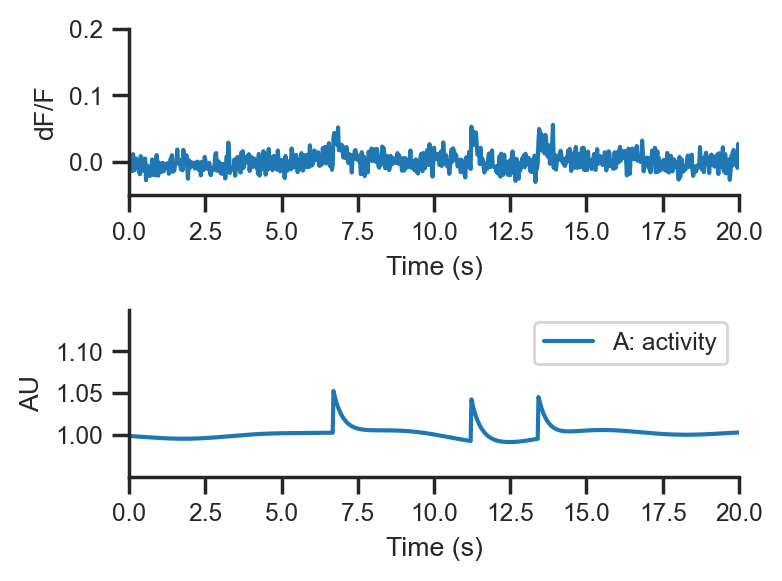

41


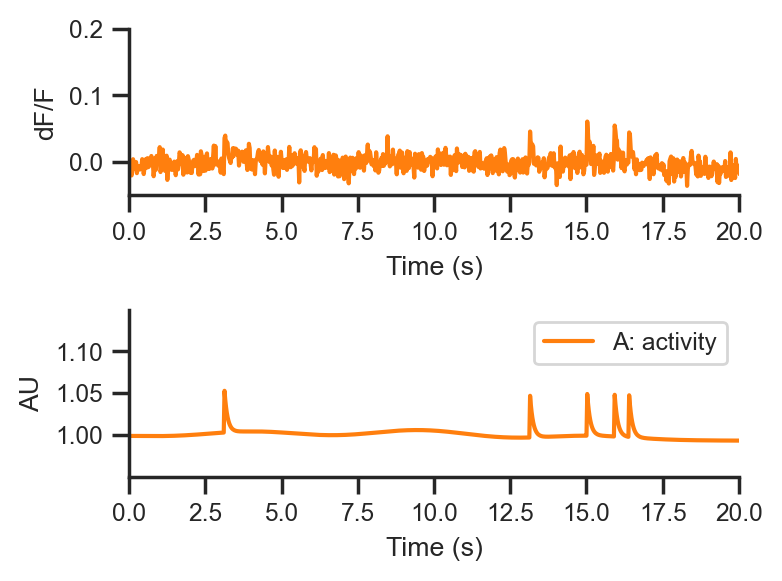

In [5]:
# This section is a check on how well the hardware separates sources
# dims are tjl for O


def df_over_f(x):
    mean_x = np.mean(x)
    return (x - mean_x) / mean_x


cmap = plt.get_cmap("tab10", lut=8)
for i, j, wavelength in [(0, 1, 530), (1, 2, 610)]:
    # find index for closest wavelength
    l = np.argmin(np.abs(sim.L_arr - wavelength))
    print(l)

    f, ax = plt.subplots(2, figsize=(4, 3))
    ax[0].plot(sim.T_arr[:], df_over_f(dat["O"][:, j, l]), c=cmap(i), label=f"{sim.L_arr[l]:0.2f}")
    ax[0].set(xlabel="Time (s)", ylabel="dF/F", xlim=(0, 20), ylim=(-0.05, 0.2))

    ax[1].plot(sim.T_arr, dat["A"][:, i], c=cmap(i), label="A: activity")
    ax[1].set(xlabel="Time (s)", ylabel="AU", xlim=(0, 20), ylim=(0.95, 1.15), yticks=[1.0, 1.05, 1.1])
    plt.tight_layout()
    plt.legend()
    plt.show()

DA signal is excited by the 560 laser, and peak emission is at ~610 nm 
       Channel 2 = 560 nm laser


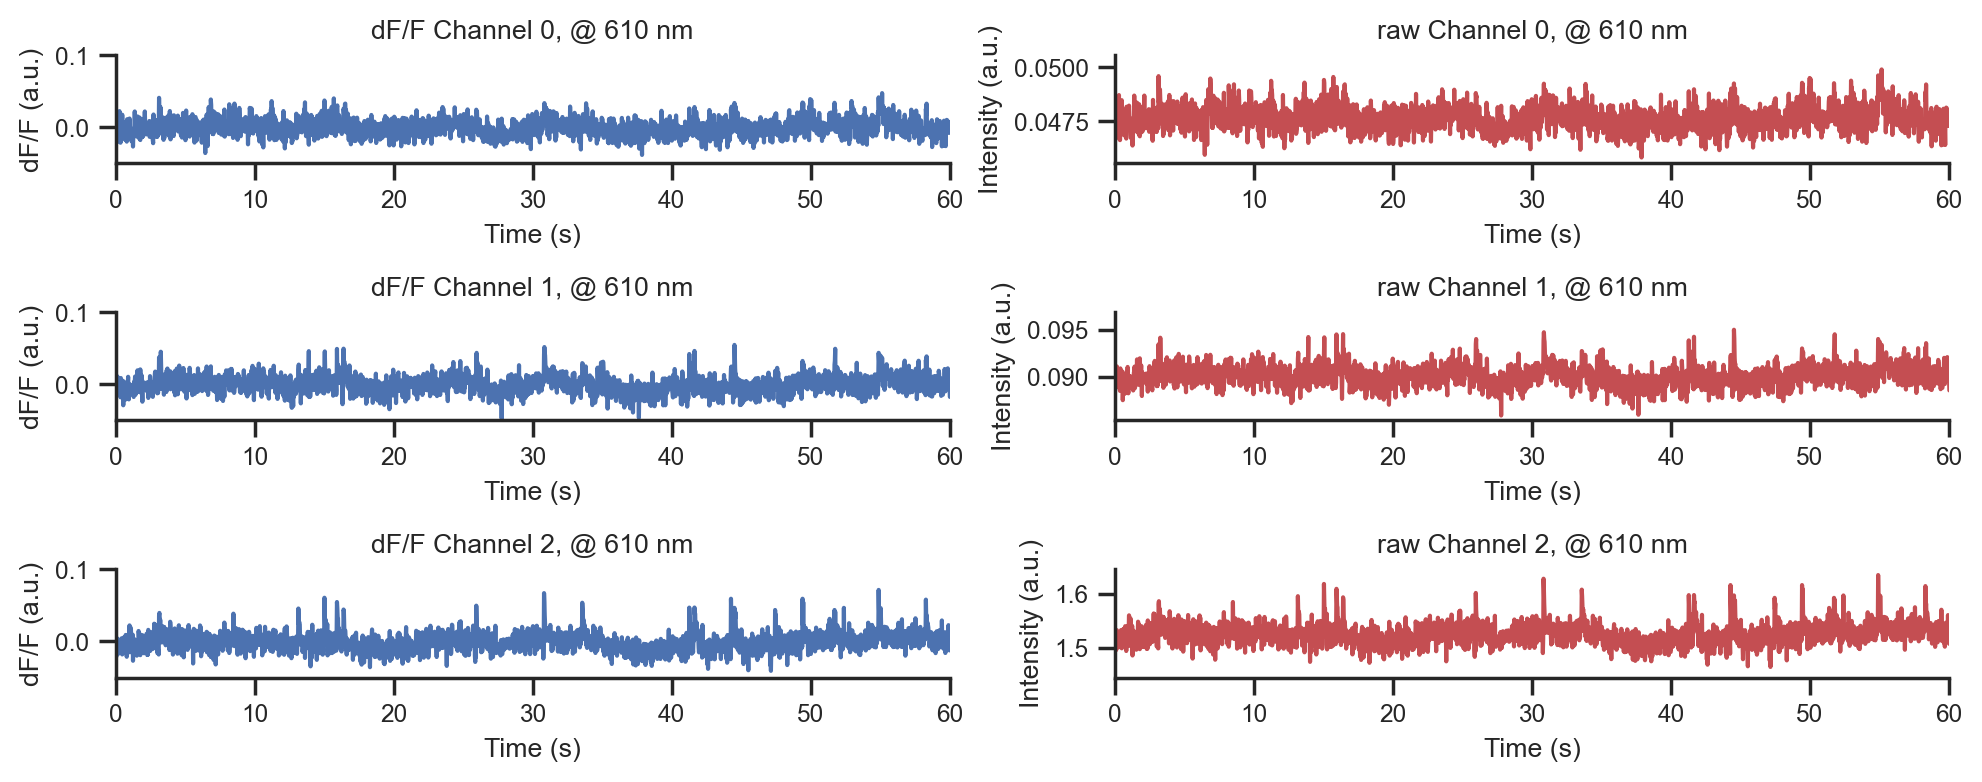


Ca signal is excited by the 473 laser, and emitted at 530 nm 
       Channel 1 = 473 nm laser


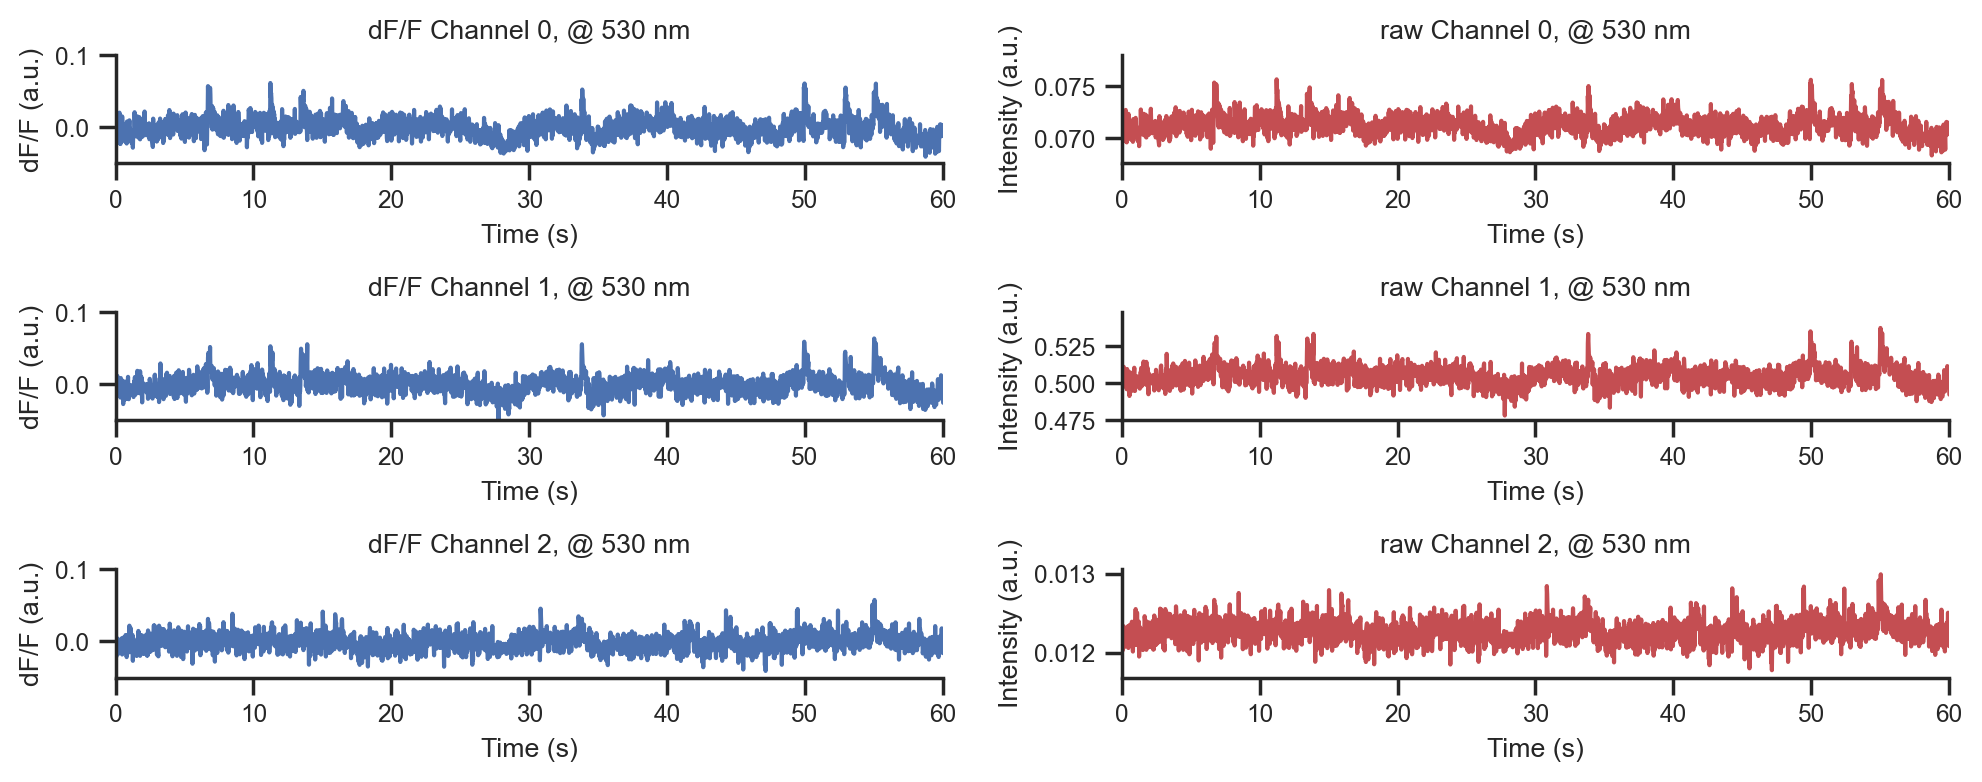


405 laser does not excite either sensor 
       Channel 0 = 405 nm laser


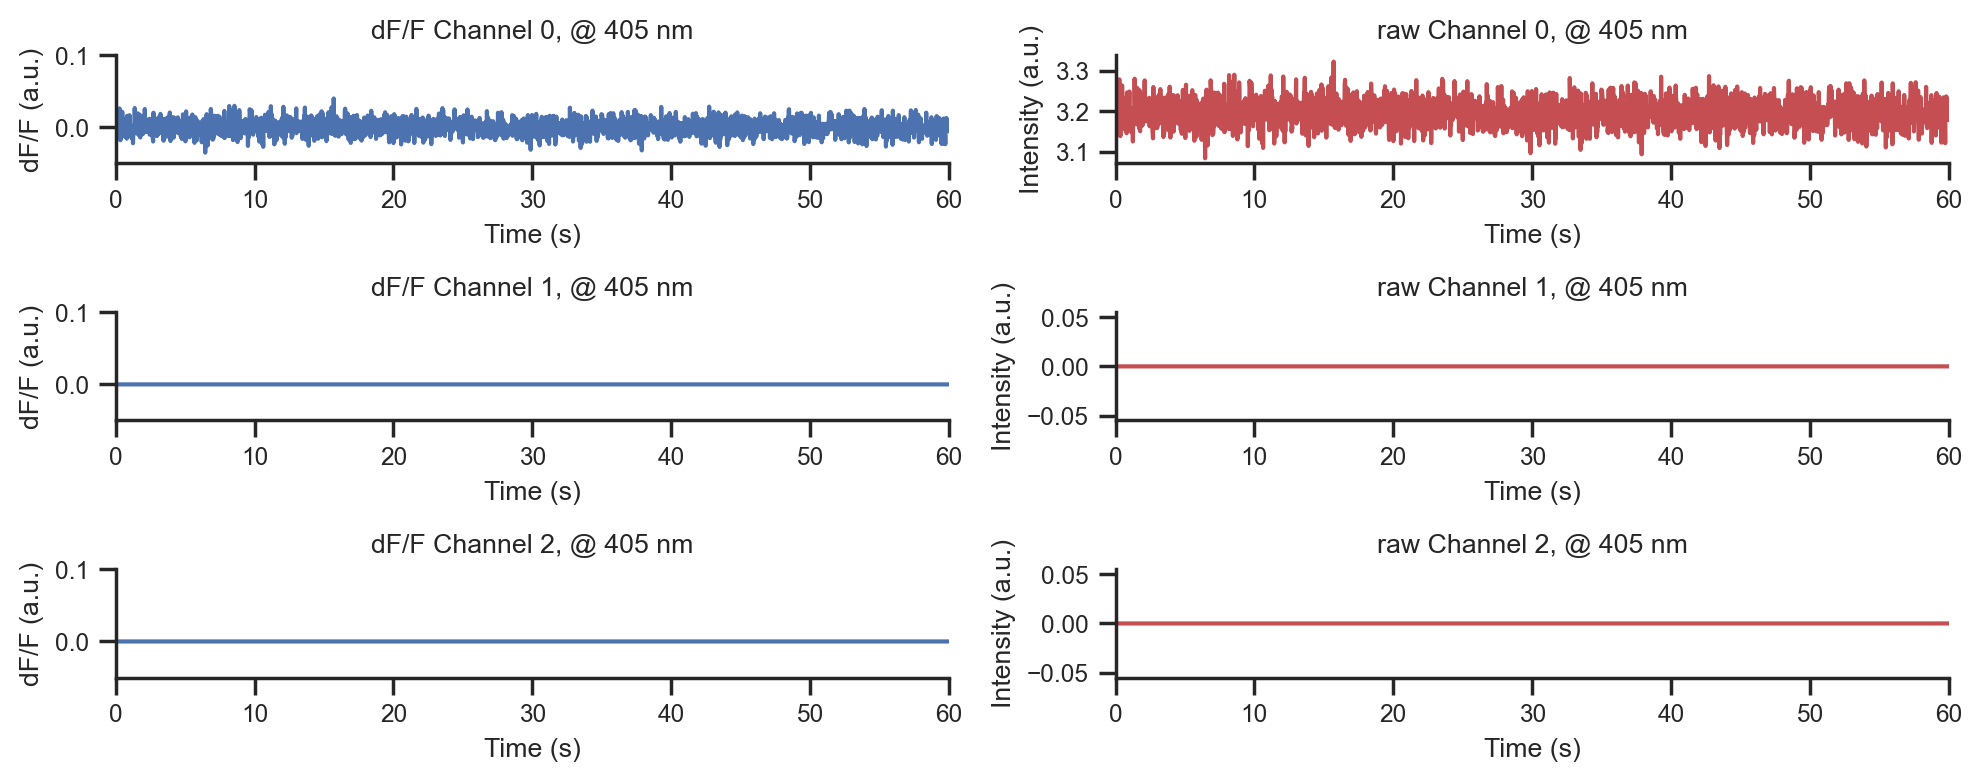

In [6]:
# reshaping to match data analysis of Ca-DA signal
xj = [None] * 3
for j in range(3):
    xj[j] = np.squeeze(dat["O"][:, j, :])

l = sim.L_arr
t = sim.T_arr


def df_over_f(x):
    mean_x = np.mean(x)
    return (x - mean_x) / (mean_x + 1e-6)


def plot_channels(l, t, xj, em_freq, xlim=(0, 60)):
    c_ind = np.argmin(np.abs(l - em_freq))

    f, ax = plt.subplots(3, 2, figsize=(10, 4))
    k = 0
    for i in range(3):
        ax[i, k].plot(t.ravel(), df_over_f(xj[i][:, c_ind].ravel()))
        ax[i, k].set(
            xlim=xlim,
            ylim=(-0.05, 0.1),
            xlabel="Time (s)",
            ylabel="dF/F (a.u.)",
            title=f"dF/F Channel {i}, @ {em_freq} nm",
        )
    k = 1
    for i in range(3):
        ax[i, k].plot(t.ravel(), xj[i][:, c_ind].ravel(), c="r")
        ax[i, k].set(xlim=xlim, xlabel="Time (s)", ylabel="Intensity (a.u.)", title=f"raw Channel {i}, @ {em_freq} nm")

    plt.tight_layout()
    plt.show()
    return


print(
    "DA signal is excited by the 560 laser, and peak emission is at ~610 nm \n \
      Channel 2 = 560 nm laser"
)
plot_channels(l, t, xj, em_freq=610, xlim=(0, 60))

print(
    "\nCa signal is excited by the 473 laser, and emitted at 530 nm \n \
      Channel 1 = 473 nm laser"
)
plot_channels(l, t, xj, em_freq=530, xlim=(0, 60))

print(
    "\n405 laser does not excite either sensor \n \
      Channel 0 = 405 nm laser"
)
plot_channels(l, t, xj, em_freq=405, xlim=(0, 60))

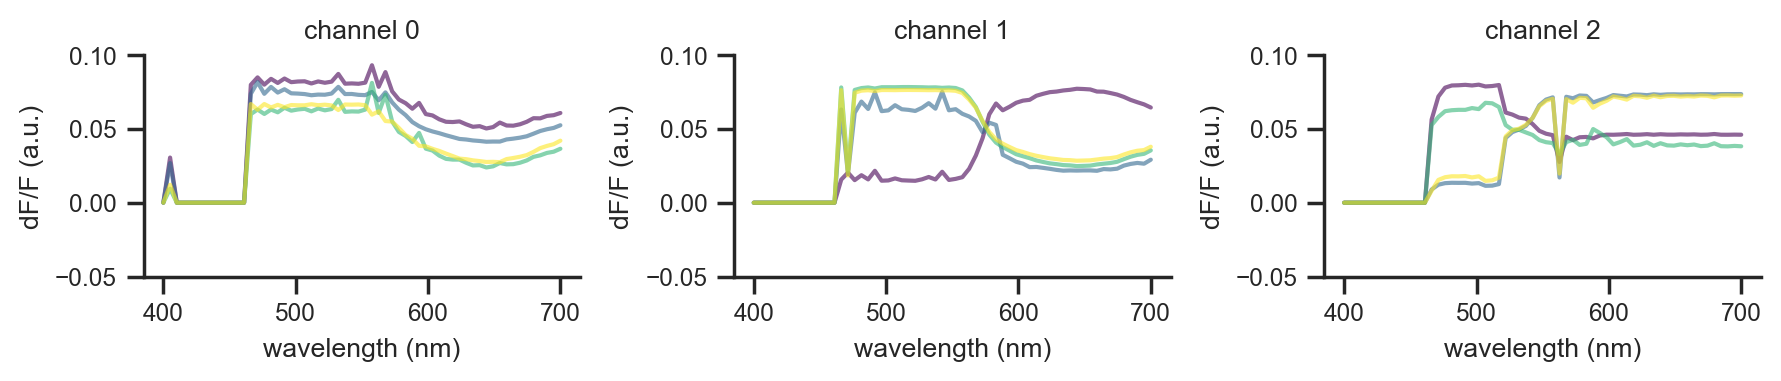

In [7]:
# reshaping to match data analysis of Ca-DA signal
xj = [None] * 3
for j in range(3):
    xj[j] = np.squeeze(dat["O"][:, j, :])

l = sim.L_arr
t = sim.T_arr

# same as before, but now considering df/f
t = sim.T_arr
t_window = 100.0
l_ind = np.arange(l.size)
l_ind = l_ind[l[l_ind] > 500]
J = 3


def df_over_f_ax0(x):
    mean_x = np.mean(x, axis=0, keepdims=True)
    return (x - mean_x) / (mean_x + 1e-6)


max_xj = [None] * J
Xj = [df_over_f_ax0(xj[j]) for j in range(J)]
for j in range(J):
    # X = df_over_f_ax0(xj[j][:, l_ind])
    X = Xj[j]
    row_inds = []
    for t_start in np.arange(0, np.max(t), t_window):
        t_end = t_start + np.min([t_window, np.max(t) - t_start])
        ind = np.where((t >= t_start) & (t < t_end))[0]
        ind_max = np.argmax(X[ind, :])
        r, c = np.unravel_index(ind_max, (ind.size, X.shape[1]))
        row_inds.append(ind[r])
    max_xj[j] = Xj[j][row_inds, :]

f, ax = plt.subplots(1, 3, figsize=(9, 2))
for j in range(J):
    # use a sequential colormap
    ax[j].set_prop_cycle("color", plt.cm.viridis(np.linspace(0, 1, max_xj[j].shape[0])))
    ax[j].plot(l.flatten(), max_xj[j].T, alpha=0.6)
    ax[j].set(xlabel="wavelength (nm)", ylabel="dF/F (a.u.)", ylim=(-0.05, 0.1), title=f"channel {j}")
plt.tight_layout()
plt.show()

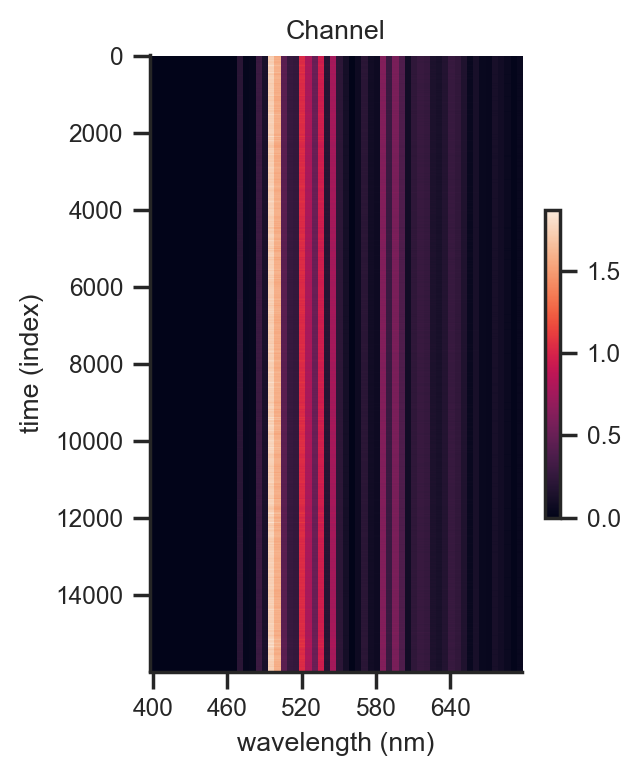

In [8]:
xim = np.squeeze(dat["O"][:, 1, :])
l = np.arange(400, 700, 1)
f, ax = plt.subplots(1, 1, figsize=(3, 4))
f.colorbar(ax.imshow(xim, interpolation="nearest", aspect="auto"), ax=ax, shrink=0.5)
ax.grid(visible=False)
ax.set(xlabel="wavelength (nm)", ylabel="time (index)", title="Channel")
ax.set_xticks(np.arange(0, 60, 12), labels=l[np.arange(0, 300, 60)])
plt.show()

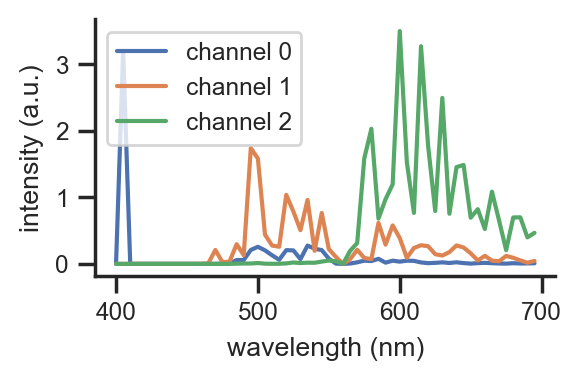

In [9]:
f, ax = plt.subplots(1, 1, figsize=(3, 2))
for j in range(3):
    xim = np.squeeze(dat["O"][:, j, :])
    ax.plot(l[np.arange(0, 300, 5)], xim.mean(axis=0), label=f"channel {j}")
    ax.set(xlabel="wavelength (nm)", ylabel="intensity (a.u.)")
    ax.legend()
plt.tight_layout()
plt.show()

In [10]:
# from sourcesep.sim import SimData
# from sourcesep.utils.config import load_config

# paths = load_config(dataset_key='all')
# sim = SimData(T=3600*4*40, cfg_path=paths['root'] / "sim_HSFP_636970_2022-11-14-12-34-14.toml")
# sim.to_disk(filepath=str(paths['root'] / "sims" / "2023-05-23_ca-da_train.h5"))

# sim = SimData(T=1800*40, cfg_path=paths['root'] / "sim_HSFP_636970_2022-11-14-12-34-14.toml")
# sim.to_disk(filepath=str(paths['root'] / "sims" / "2023-05-23_ca-da_val.h5"))